# Data analysis: Velib

Author: O. Roustant, INSA Toulouse. February 2022.


We consider the ‘Vélib’ data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). The aim is to detect clusters in the data, corresponding to common customer usages. This clustering should then be used to predict the loading profile.

In [1]:
rm(list = ls())   # erase everything, start from scratch!

# load the data from package funFEM
library("FactoMineR")
library("funFEM")
data(velib)
help("velib")
#str(velib)

Le chargement a nécessité le package : MASS

Le chargement a nécessité le package : fda

Le chargement a nécessité le package : splines

Le chargement a nécessité le package : Matrix

Le chargement a nécessité le package : fds

Le chargement a nécessité le package : rainbow

Le chargement a nécessité le package : pcaPP

Le chargement a nécessité le package : RCurl

Le chargement a nécessité le package : deSolve


Attachement du package : 'fda'


L'objet suivant est masqué depuis 'package:graphics':

    matplot


Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.2




In [2]:
# data preparation
x <- as.matrix(velib$data)
colnames(x) <- 1:ncol(x)
rownames(x) <- velib$names


# select exactly 7 days of data (we remove the first 13 dates)
dates <- 14:181
x <- x[, dates]
colnames(x) <- 1:length(dates)
head(x)

,1,2,3,4,5,6,7,8,9,10,⋯,159,160,161,162,163,164,165,166,167,168
EURYALE DEHAYNIN,0.03846154,0.03846154,0.07692308,0.03846154,0.03846154,0.03846154,0.03846154,0.03846154,0.10714286,0.00000000,⋯,0.29629630,0.11111111,0.1111111,0.14814815,0.30769231,0.07692308,0.11538462,0.07692308,0.1538462,0.1538462
LEMERCIER,0.47826087,0.47826087,0.47826087,0.43478261,0.43478261,0.43478261,0.43478261,0.43478261,0.26086957,0.04347826,⋯,0.04347826,0.00000000,0.2173913,0.13043478,0.04545455,0.17391304,0.17391304,0.17391304,0.2608696,0.3913043
MEZIERES RENNES,0.21818182,0.14545455,0.12727273,0.10909091,0.10909091,0.10909091,0.09090909,0.09090909,0.05454545,0.10909091,⋯,0.25925926,0.25925926,0.2037037,0.12962963,0.14814815,0.29629630,0.31481481,0.37037037,0.3703704,0.4074074
FARMAN,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,0.95238095,1.00000000,1.00000000,1.00000000,⋯,1.00000000,1.00000000,0.9047619,0.85714286,0.85714286,0.85714286,0.76190476,0.76190476,0.7619048,0.7619048
QUAI DE LA RAPEE,0.92753623,0.81159420,0.73913043,0.72463768,0.72463768,0.72463768,0.72463768,0.72463768,0.75362319,0.97101449,⋯,0.22727273,0.45454545,0.5909091,0.83333333,1.00000000,0.81818182,0.63636364,0.71212121,0.6212121,0.5757576
CHOISY POINT D'IVRY,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.16666667,0.08333333,0.00000000,⋯,0.34782609,0.08695652,0.1153846,0.08695652,0.13043478,0.08695652,0.08695652,0.43478261,0.3913043,0.5217391


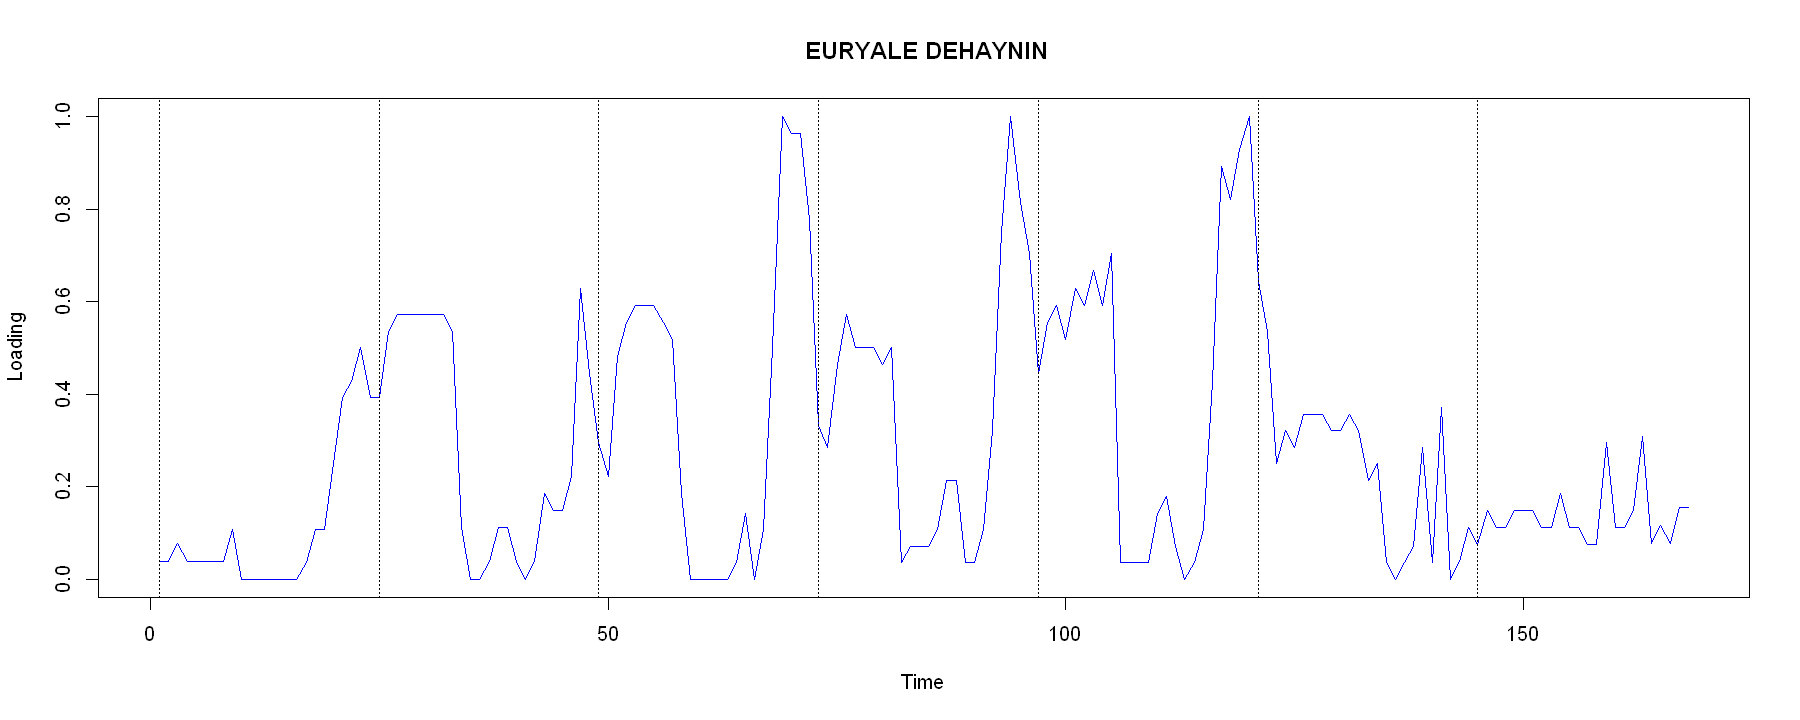

In [3]:
timeTick <- 1 + 24*(0:6)  # vector corresponding to the beginning of days
par(mfrow = c(1, 1))
options(repr.plot.width = 15, repr.plot.height = 6)

plot(x[1, ], col = "blue", type = "l", ylim = c(0, 1), 
     xlab = "Time", ylab = "Loading", main = rownames(x)[1])
abline(v = timeTick, lty = "dotted")


In [4]:
# From now on, we use numbers instead of station names, 
# in order to simplify printing
rownames(x) <- 1:nrow(x)

# Descriptive statistics.

Some ideas : 

1. Draw a matrix of plots of size 4*4, corresponding to the first 16 stations. (Do not forget the vertical lines corresponding to days).
2. Draw the boxplot of the variables, sorted in time order. 
What can you say about the distribution of the variables? 
Position, dispersion, symmetry?
3. Plot the average hourly loading for each day (on a single graph).
4. Plot the stations coordinates on a 2D map (latitude versus longitude). Use the package ggmap (function 'qmplot') to visualize the average loading for a given hour (6h, 12h, 23h) as a color scale.
Comments ?
5. Use a different color for stations which are located on a hill. (Use the basis 'plot' function, and the function 'qmplot' of R package ggmap).
6. Redo questions 1-3 for the subset of stations which are located on a hill. Same questions for those who are not. Comment?

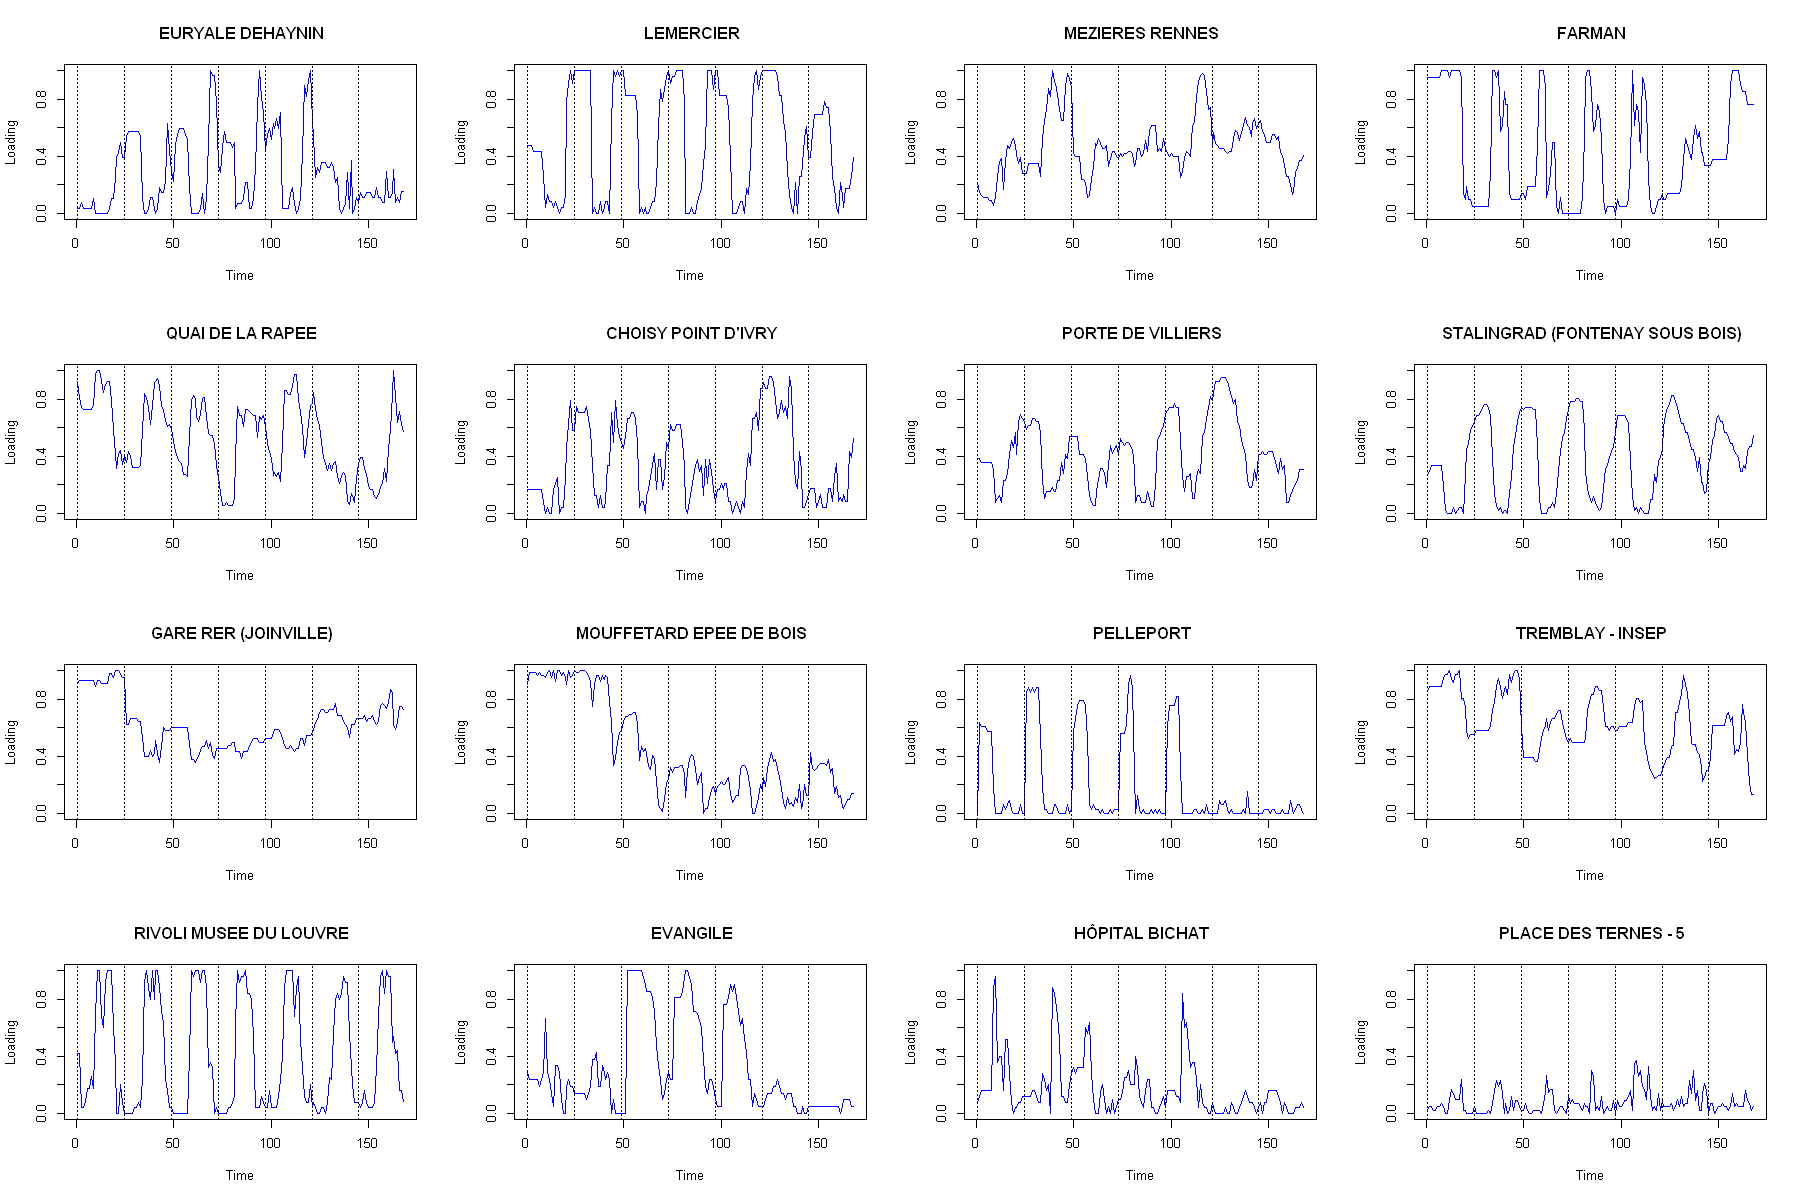

In [5]:
# Q1
par(mfrow = c(4, 4))
options(repr.plot.width = 15, repr.plot.height = 10)

for (i in 1:16){
    plot(x[i, ], col = "blue", type = "l", ylim = c(0, 1), 
         xlab = "Time", ylab = "Loading", main = velib$names[i])
    abline(v = timeTick, lty = "dotted")
}


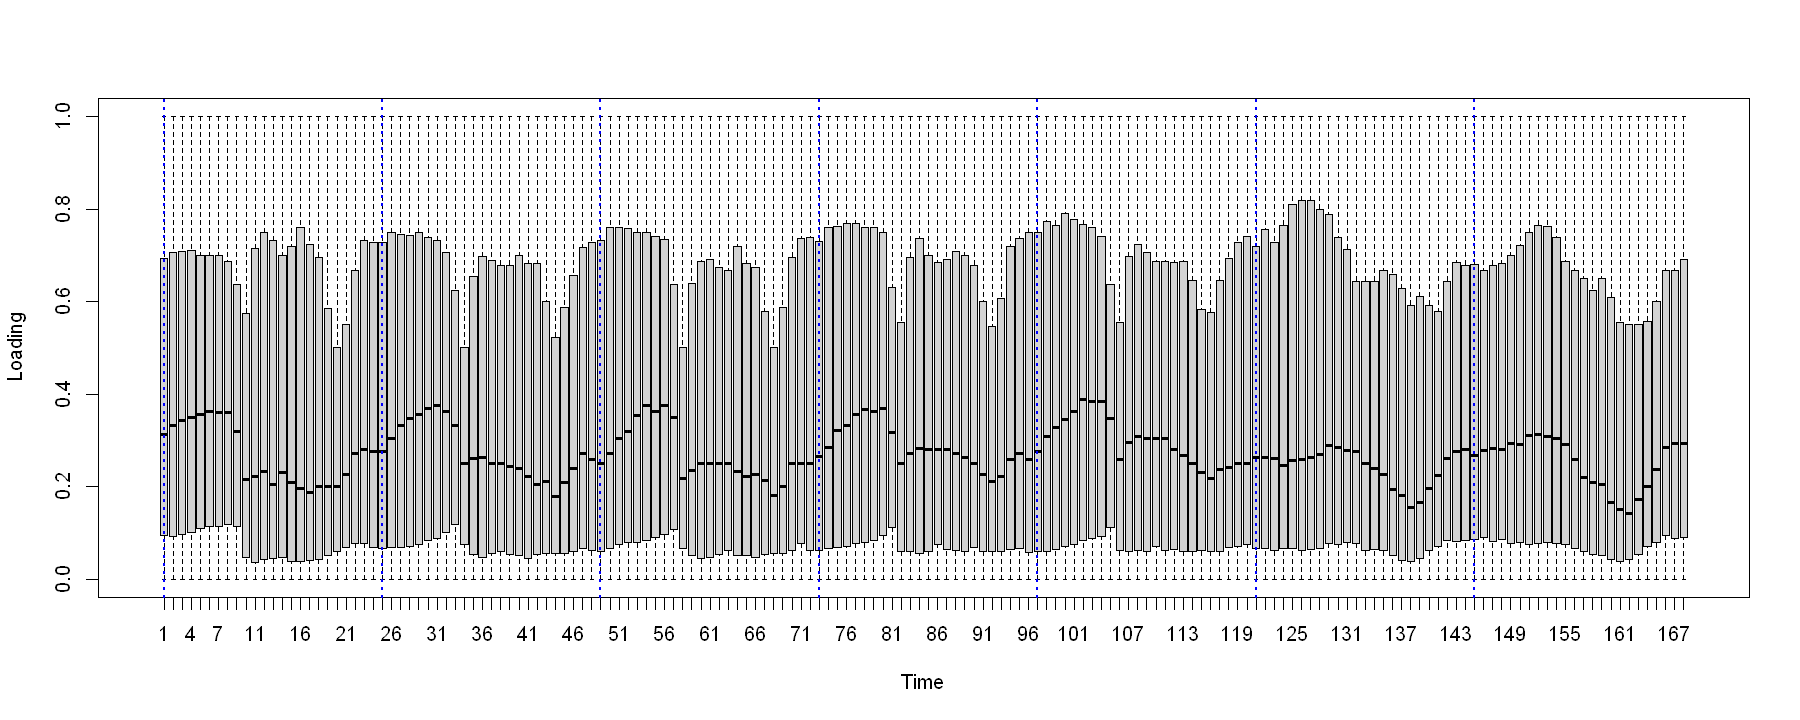

In [6]:
# Q2
options(repr.plot.width = 15, repr.plot.height = 6)
stats <- boxplot(x, xlab = "Time", ylab = "Loading")
help(boxplot)
abline(v = timeTick, lty = "dotted", col = "blue", lwd = 2)

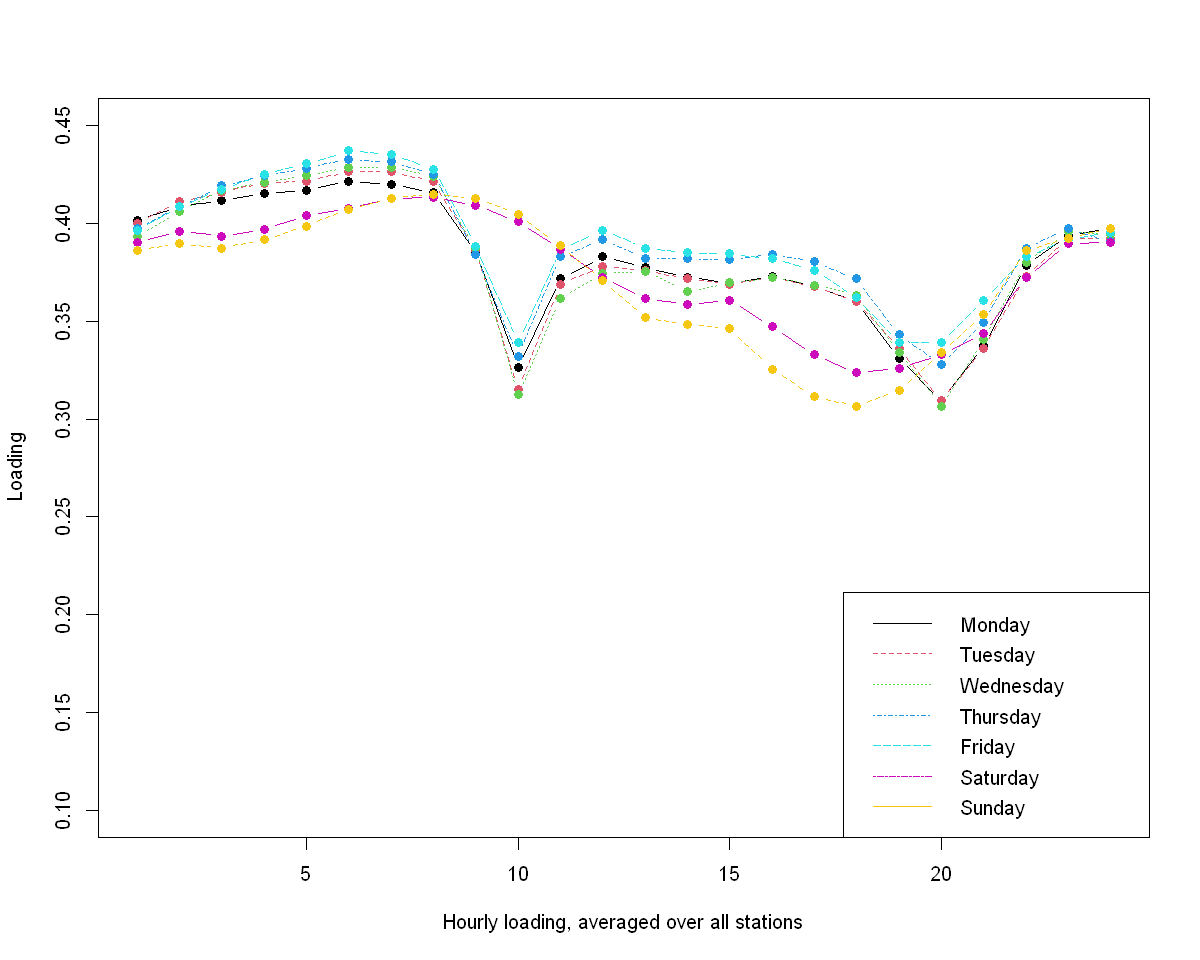

In [7]:
# Q3
xHour <- colMeans(x)
# alternatively, one can use the median returned by boxplot
# xHour <- stats$stats[3, ]
xHour <- matrix(xHour, nrow = 24)  # rearranged in columns (column 1 contains the stations 1, 2, ..., 24) 

options(repr.plot.width = 10, repr.plot.height = 8)
dayText <- c("Mon", "Tues", "Wednes", "Thurs", "Fri", "Satur", "Sun")
dayText <- paste(dayText, "day", sep = "")
matplot(xHour, type = "b", ylim = c(0.1, 0.45), col = 1:7, pch = 19, 
        xlab = "Hourly loading, averaged over all stations", ylab = "Loading")
legend("bottomright", dayText, lty = 1:7, col = 1:7)

In [8]:
str(velib)

List of 5
 $ data    :'data.frame':	1189 obs. of  181 variables:
  ..$ V1  : num [1:1189] 0.0769 0.0435 0.1091 0.5714 1 ...
  ..$ V2  : num [1:1189] 0.269 0 0.127 0.524 0.942 ...
  ..$ V3  : num [1:1189] 0.385 0.13 0.127 0.667 1 ...
  ..$ V4  : num [1:1189] 0.231 0.087 0.182 0.714 0.986 ...
  ..$ V5  : num [1:1189] 0.154 0.174 0.145 0.81 1 ...
  ..$ V6  : num [1:1189] 0.154 0.087 0.109 1 1 ...
  ..$ V7  : num [1:1189] 0.2692 0.0435 0.2545 1 1 ...
  ..$ V8  : num [1:1189] 0.08 0.0435 0.2545 0.9524 1 ...
  ..$ V9  : num [1:1189] 0.115 0.217 0.255 0.952 0.971 ...
  ..$ V10 : num [1:1189] 0.115 0.304 0.327 0.952 0.957 ...
  ..$ V11 : num [1:1189] 0.115 0.304 0.241 0.952 0.913 ...
  ..$ V12 : num [1:1189] 0.231 0.435 0.218 0.952 0.913 ...
  ..$ V13 : num [1:1189] 0.0385 0.5217 0.2182 0.9524 0.8551 ...
  ..$ V14 : num [1:1189] 0.0385 0.4783 0.2182 0.9524 0.9275 ...
  ..$ V15 : num [1:1189] 0.0385 0.4783 0.1455 0.9524 0.8116 ...
  ..$ V16 : num [1:1189] 0.0769 0.4783 0.1273 0.9524 0.7391 ...


Le chargement a nécessité le package : ggplot2

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.

Please cite ggmap if you use it! See citation("ggmap") for details.

Using zoom = 12...

Source : http://tile.stamen.com/terrain/12/2073/1408.png

Source : http://tile.stamen.com/terrain/12/2074/1408.png

Source : http://tile.stamen.com/terrain/12/2075/1408.png

Source : http://tile.stamen.com/terrain/12/2076/1408.png

Source : http://tile.stamen.com/terrain/12/2073/1409.png

Source : http://tile.stamen.com/terrain/12/2074/1409.png

Source : http://tile.stamen.com/terrain/12/2075/1409.png

Source : http://tile.stamen.com/terrain/12/2076/1409.png

Source : http://tile.stamen.com/terrain/12/2073/1410.png

Source : http://tile.stamen.com/terrain/12/2074/1410.png

Source : http://tile.stamen.com/terrain/12/2075/1410.png

Source : http://tile.stamen.com/terrain/12/2076/1410.png



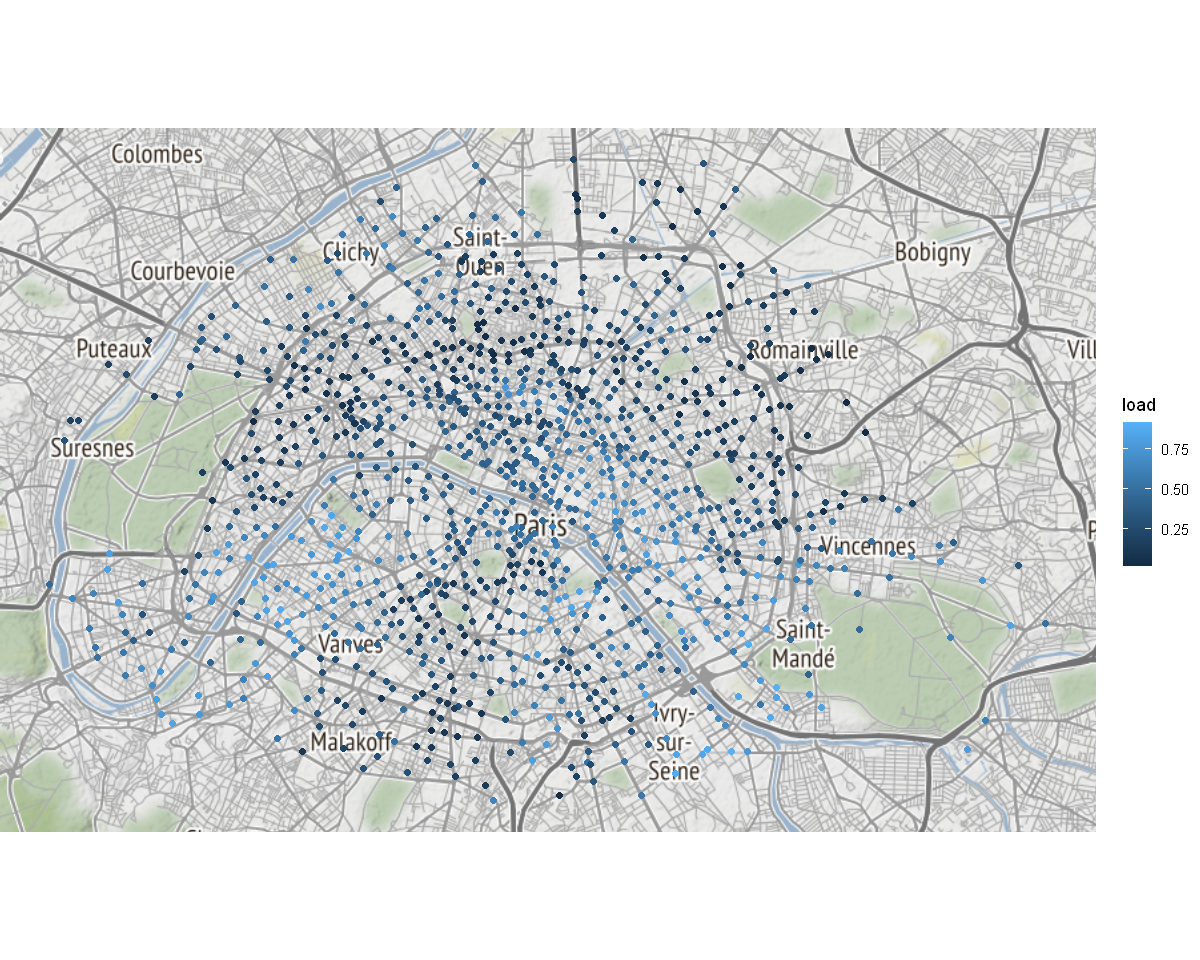

In [9]:
# Q4
library(ggmap)
# Average loading for each station
load <- rowMeans(x)  
qmplot(longitude, latitude, data = velib$position, color = load)
# Average loading at 6h, 12h et 23h (the first time step is 0h)

load6 <- rowMeans(x[, seq(from = 6, by = 24, length = 7)])
load12 <- rowMeans(x[, seq(from = 13, by = 24, length = 7)])
load23 <- rowMeans(x[, seq(from = 24, by = 24, length = 7)])
# decommenter les lignes ci-dessous pour execution
# qmplot(longitude, latitude, data = velib$position, color = load6)
# qmplot(longitude, latitude, data = velib$position, color = load12)
# qmplot(longitude, latitude, data = velib$position, color = load23)


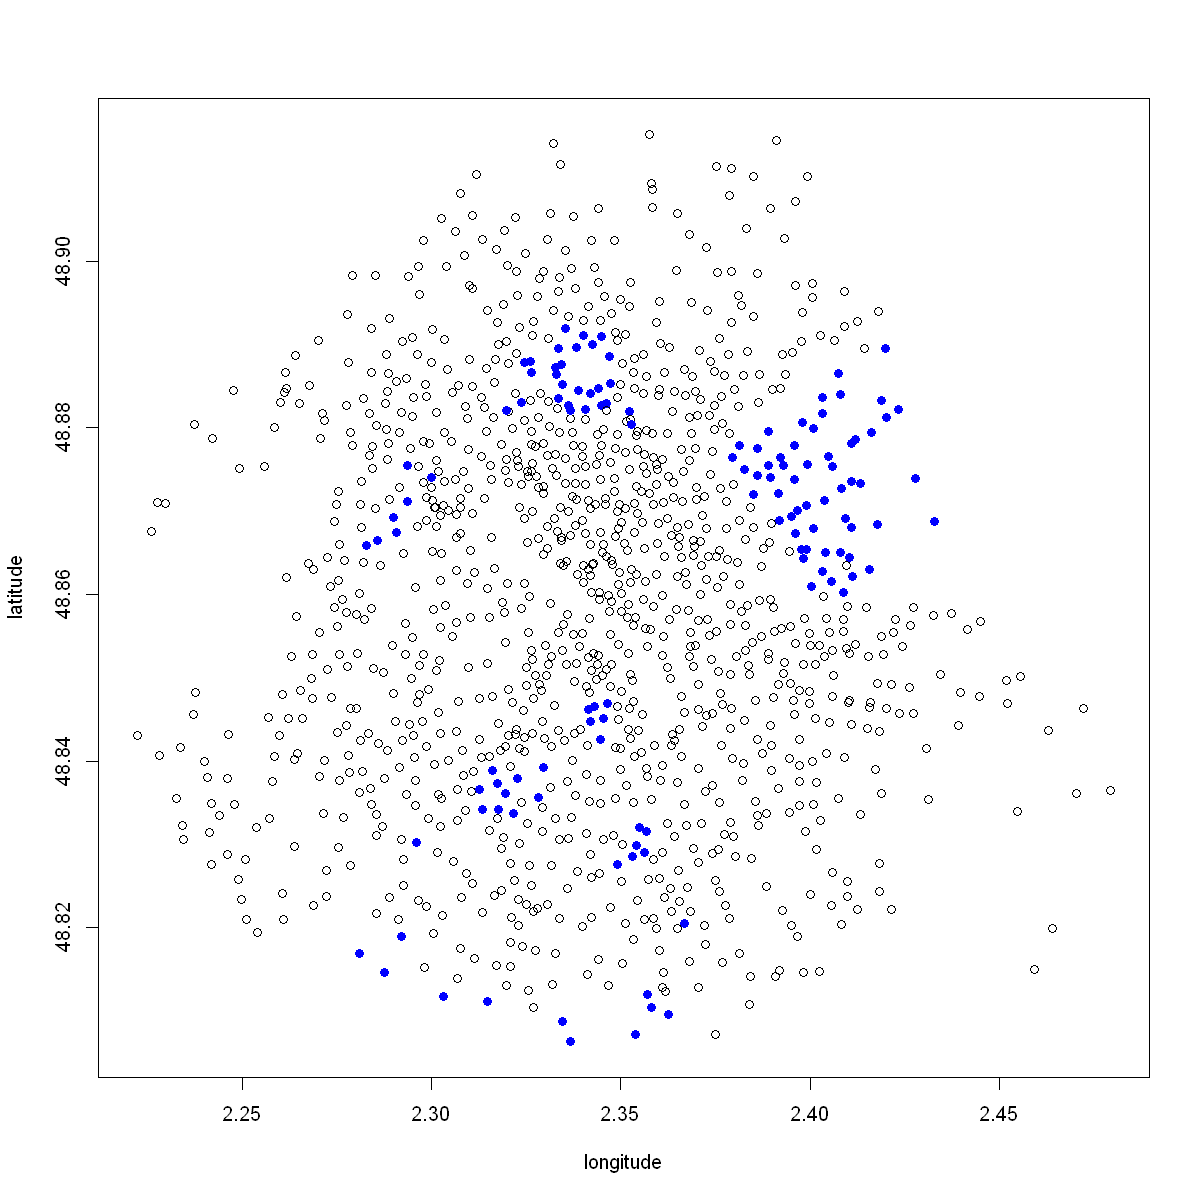

In [10]:
# Q5
options(repr.plot.width = 10, repr.plot.height = 10)
plot(velib$position, col = ifelse(velib$bonus, "blue", "black"), 
     pch = ifelse(velib$bonus, 19, 1))
# With ggmap
# Decommenter pour executer
# qmplot(longitude, latitude, data = velib$position, color = velib$bonus)

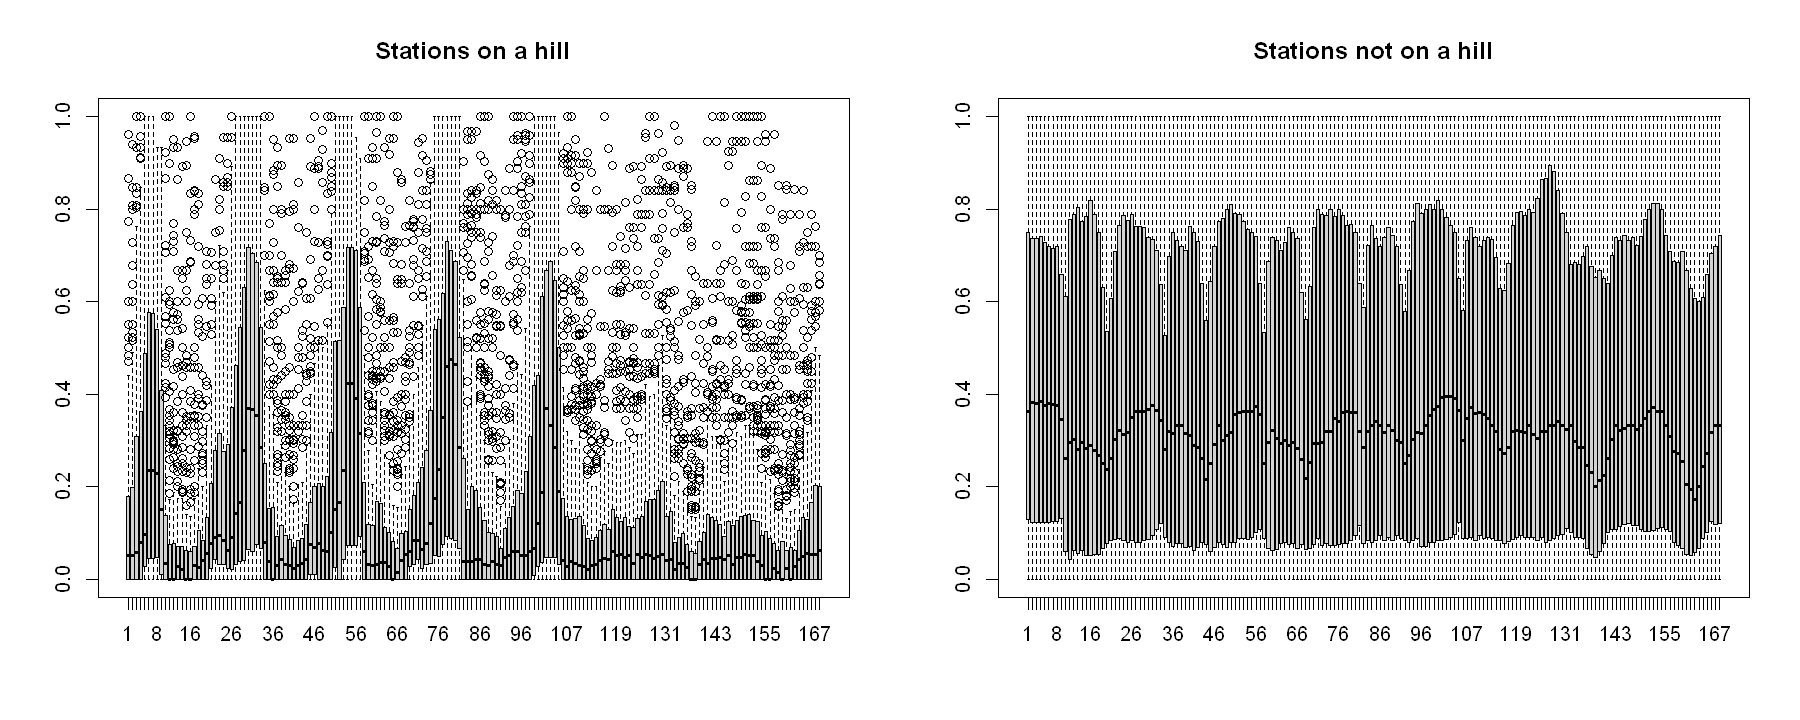

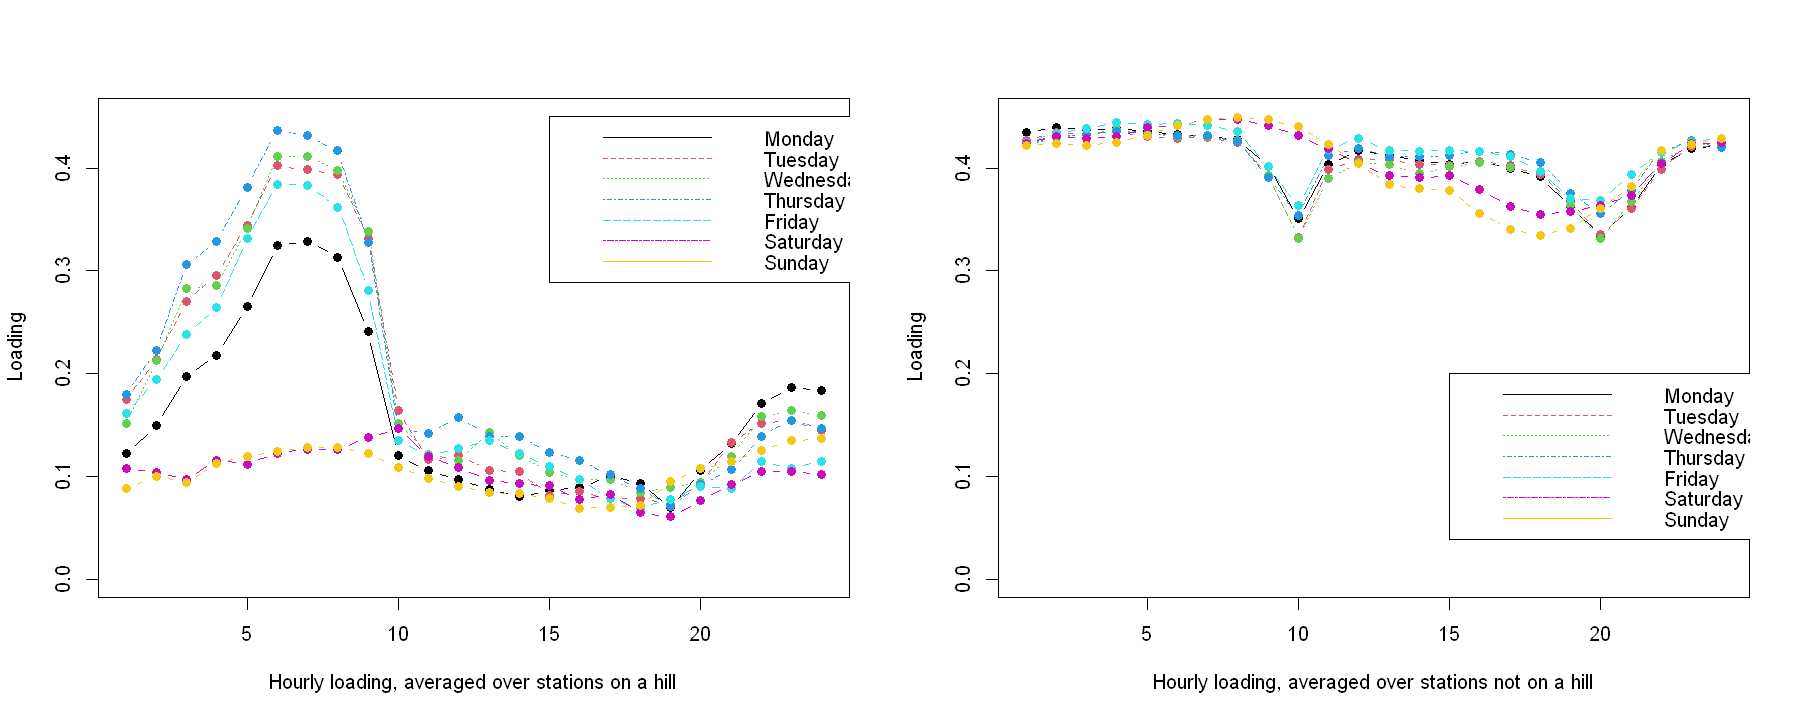

In [11]:
# Q6
xHill <- x[velib$bonus == 1, ]
xNoHill <- x[velib$bonus == 0, ]
options(repr.plot.width = 15, repr.plot.height = 6)
par(mfrow = c(1, 2))
boxplot(xHill, main = "Stations on a hill")
boxplot(xNoHill, main = "Stations not on a hill")

xHourHill <- matrix(colMeans(xHill), nrow = 24)
xHourNoHill <- matrix(colMeans(xNoHill), nrow = 24)
options(repr.plot.width = 15, repr.plot.height = 6)
par(mfrow = c(1, 2))
matplot(xHourHill, type = "b", ylim = c(0, 0.45), col = 1:7, pch = 19, 
        xlab = "Hourly loading, averaged over stations on a hill", ylab = "Loading")
legend(x = 15, y = 0.45, dayText, lty = 1:7, col = 1:7)
matplot(xHourNoHill, type = "b", ylim = c(0, 0.45), col = 1:7, pch = 19, 
        xlab = "Hourly loading, averaged over stations not on a hill", ylab = "Loading")
legend(x = 15, y = 0.2, dayText, lty = 1:7, col = 1:7)


## PCA on Velib data

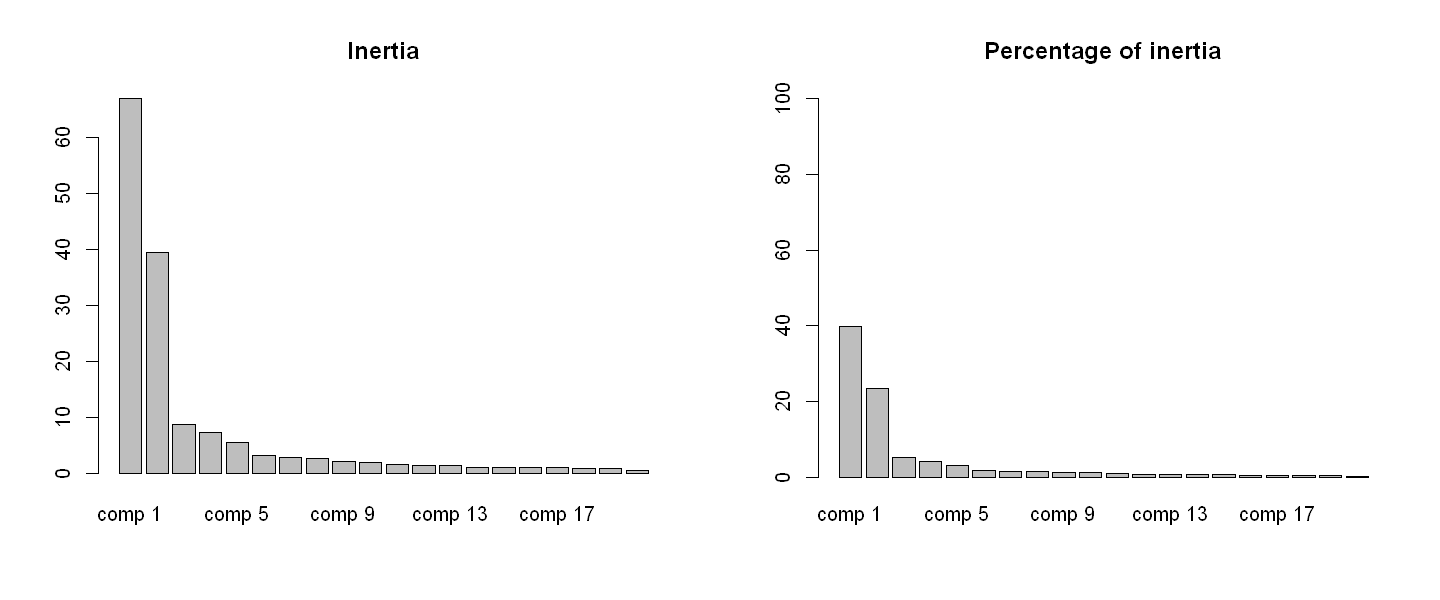

In [43]:
# PCA with FactoMineR
acp <- PCA(x, scale.unit = TRUE, ncp = 12, graph = F)
options(repr.plot.width = 12, repr.plot.height = 5)
# barplot of the inertias and percentage of inertia associated to each principal component
par(mfrow = c(1, 2))
barplot(acp$eig[1:20, 1], main = "Inertia")
barplot(acp$eig[1:20, 2], ylim = c(0, 100), main = "Percentage of inertia")

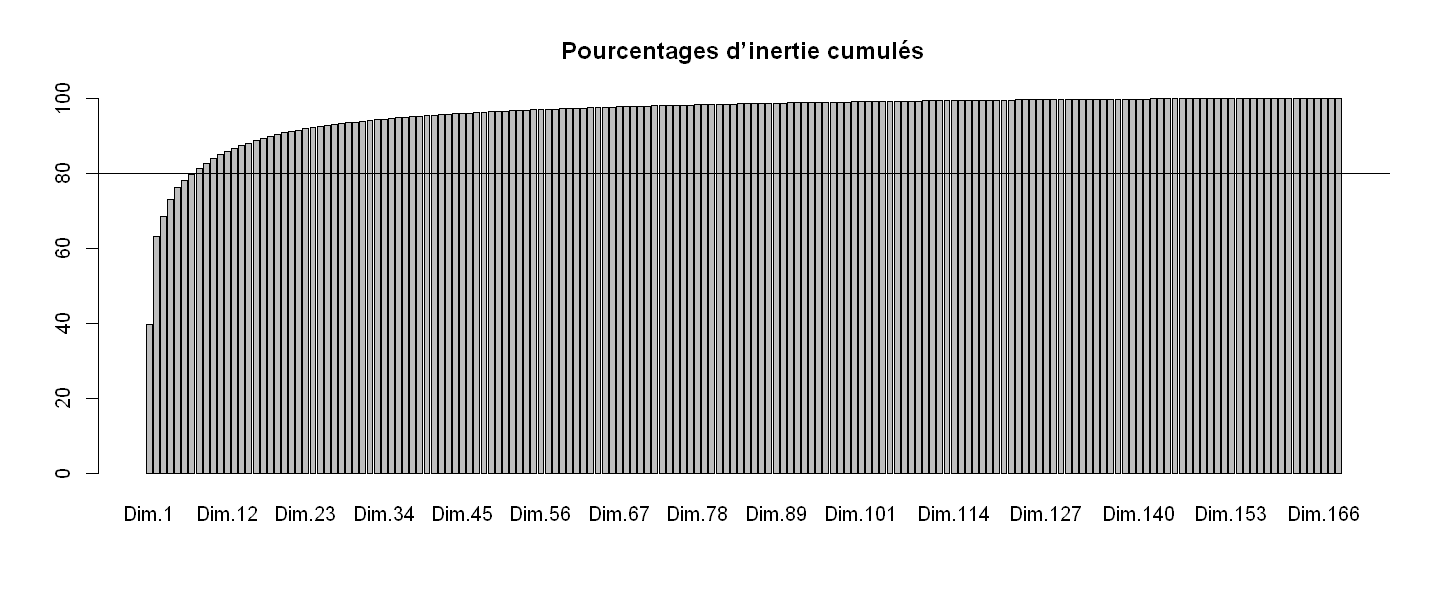

In [13]:
barplot(cumsum(acp$eig[,"percentage of variance"]), names.arg=paste("Dim",1:168,sep="."), main="Pourcentages d’inertie cumulés")
abline(h=80)


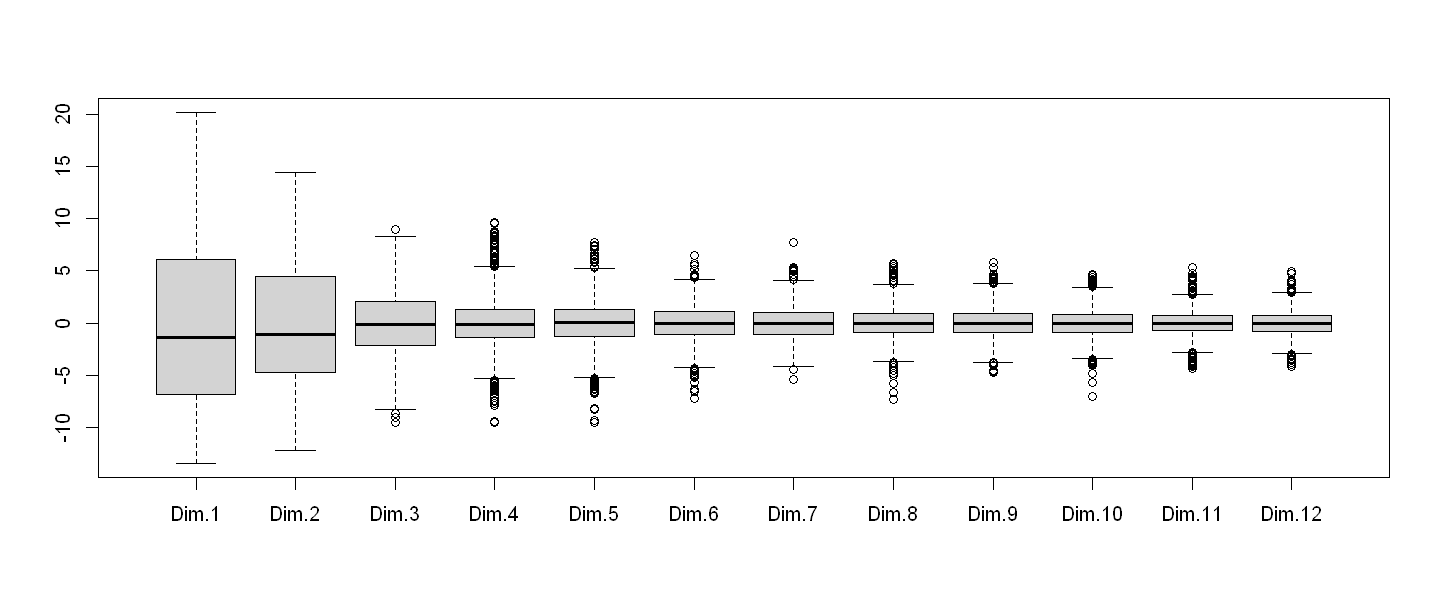

In [14]:
# Distribution of individual coordinates on the principal axes (the "principal components")
boxplot(acp$ind$coord)

In [15]:
# Orthogonal matrix P whose columns contain the eigenvectors of the PCA
P <- acp$svd$V
head(P)
head(t(P) %*% P) #close to Identity !

0.09138904,0.004075105,0.01756817,-0.01658705,-0.1992519,-0.1042312,0.04243223,-0.0427493732,-0.067936800,-0.04113270,-0.02391843,-0.009493319
0.08927933,-0.006156936,0.04216636,-0.02190522,-0.2077386,-0.1186503,0.06957424,-0.0378476027,-0.052740400,-0.06947061,-0.03424365,-0.022569735
0.08598126,-0.015860282,0.06514226,-0.02760982,-0.2178431,-0.1256034,0.09906552,-0.0337041360,-0.039598665,-0.09753025,-0.02997963,-0.004769065
0.08574385,-0.020318189,0.06978135,-0.03229235,-0.2183928,-0.1279753,0.09991031,-0.0300930721,-0.035056992,-0.10195121,-0.03320925,0.008827761
0.08289062,-0.025506147,0.08311969,-0.03351234,-0.2207544,-0.1201732,0.12484127,-0.0185481581,-0.020941281,-0.11147262,-0.03505936,0.015919744
0.07965412,-0.029277584,0.09247220,-0.03276103,-0.2192818,-0.1144458,0.14967137,-0.0003434222,-0.005831115,-0.11845711,-0.03918149,0.026489436


1.000000e+00,-1.412670e-16,7.044173e-17,-9.723605e-17,5.934957e-17,3.785981e-18,-8.072809e-17,6.590767e-17,2.535395e-17,-2.200538e-16,1.731610e-18,-6.348122e-17
-1.412670e-16,1.000000e+00,2.117908e-16,2.398100e-16,-3.178063e-17,-3.103037e-16,1.763184e-16,-1.017379e-17,-1.363845e-16,-2.220407e-16,6.017398e-17,3.278058e-17
7.044173e-17,2.117908e-16,1.000000e+00,9.367193e-17,2.342904e-16,3.143726e-16,-6.153289e-17,8.680901e-17,3.393375e-18,-5.674340e-17,-8.362073e-17,-1.106833e-16
-9.723605e-17,2.398100e-16,9.367193e-17,1.000000e+00,1.617490e-16,3.849054e-16,6.178671e-17,-1.341037e-16,4.723004e-17,2.612228e-18,-8.043927e-17,-9.324190e-17
5.934957e-17,-3.178063e-17,2.342904e-16,1.617490e-16,1.000000e+00,-6.553662e-16,3.536644e-16,-6.476715e-17,-4.744511e-17,1.338118e-16,2.373212e-17,3.083311e-17
3.785981e-18,-3.103037e-16,3.143726e-16,3.849054e-16,-6.553662e-16,1.000000e+00,3.889016e-16,-3.820057e-16,2.399748e-16,4.613300e-17,1.426275e-16,-2.692956e-17


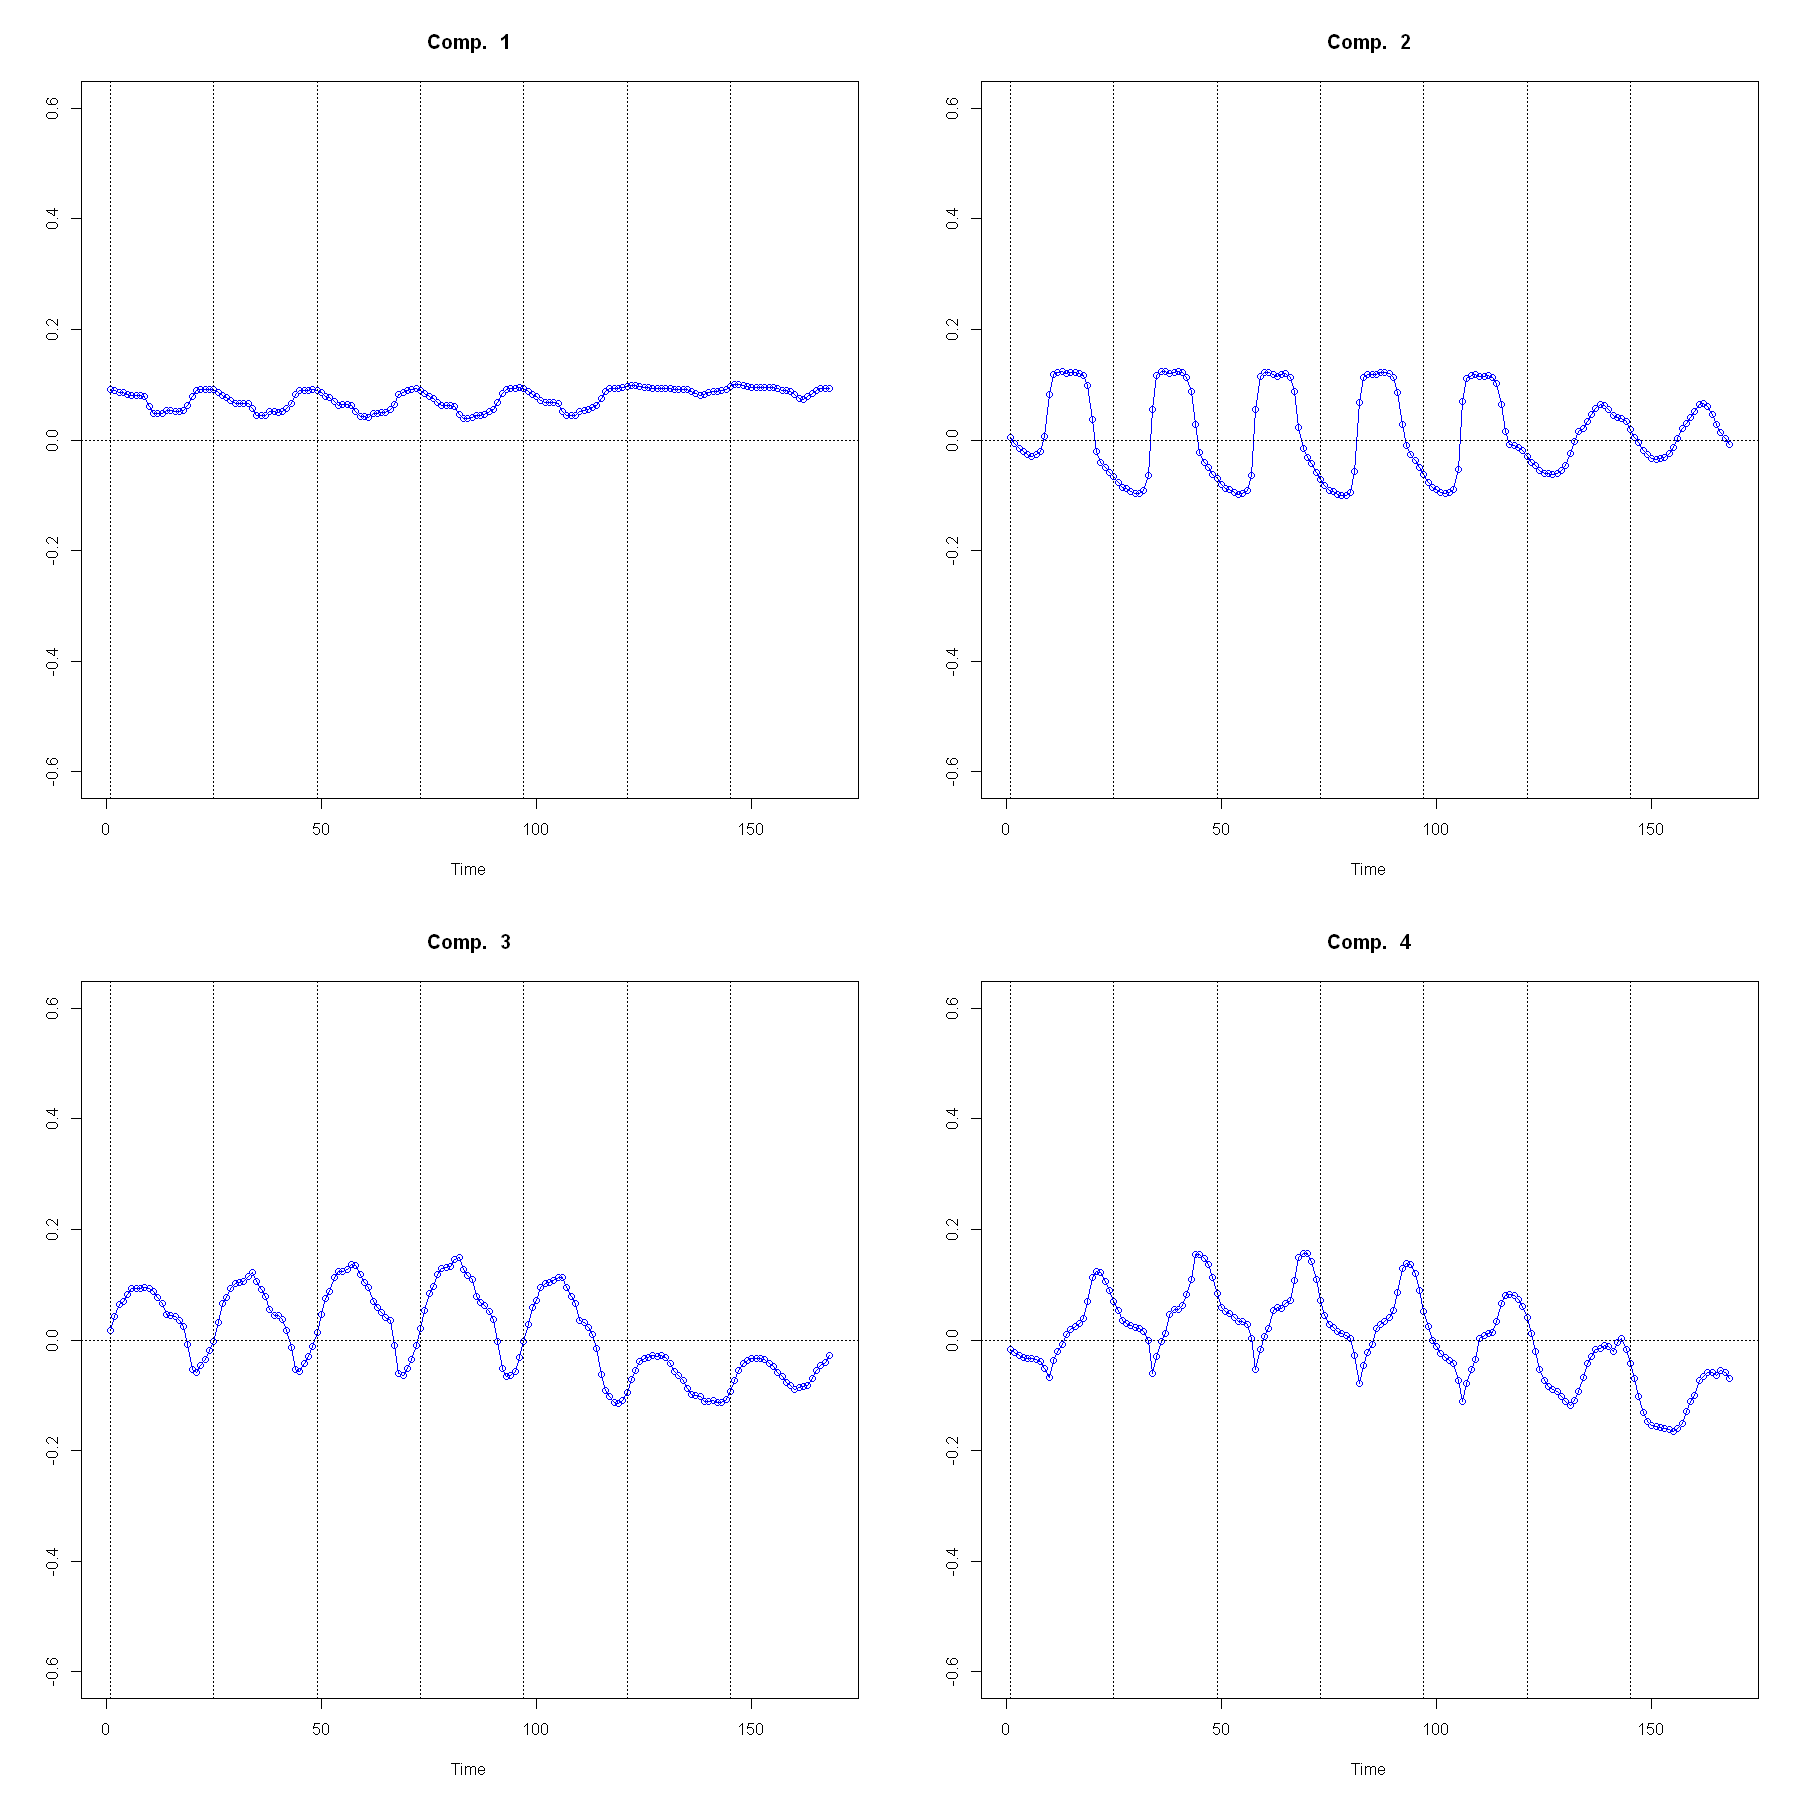

In [50]:
Timetick = 1224*c(0:6)
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow = c(2, 2))
for (i in 1:4){
    plot(acp$svd$V[, i], type = "o", main = paste("Comp. ", i), xlab = "Time", ylab = "",
         ylim = c(-0.6, 0.6), col = "blue")
    abline(h = 0, lty = "dotted")
    abline(v=timeTick, lty = "dotted")
}

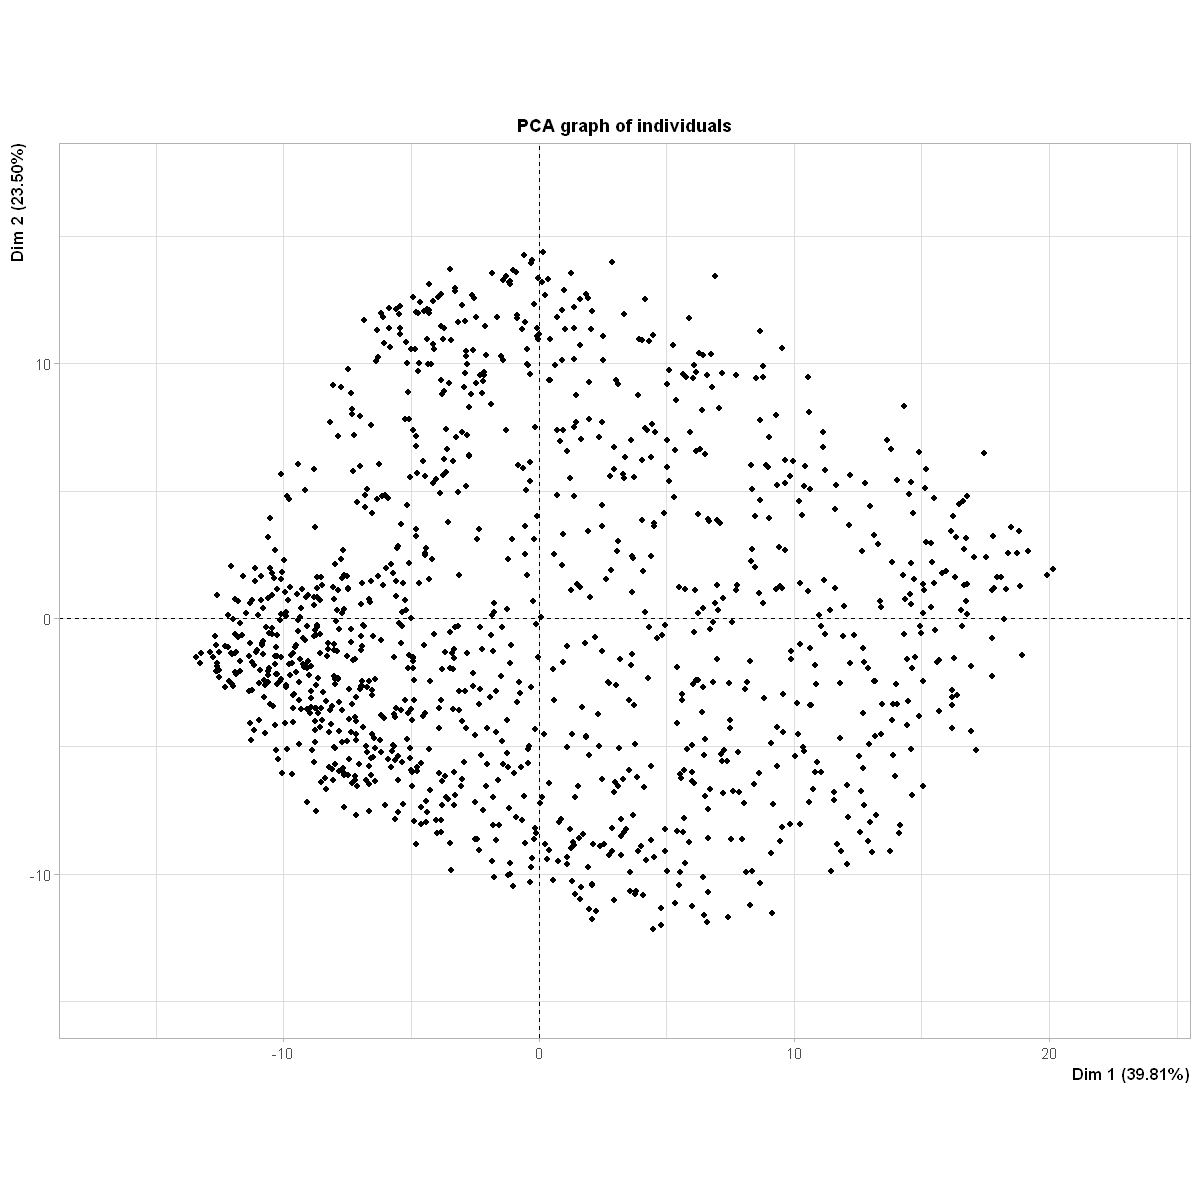

In [17]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot(acp, label="none")

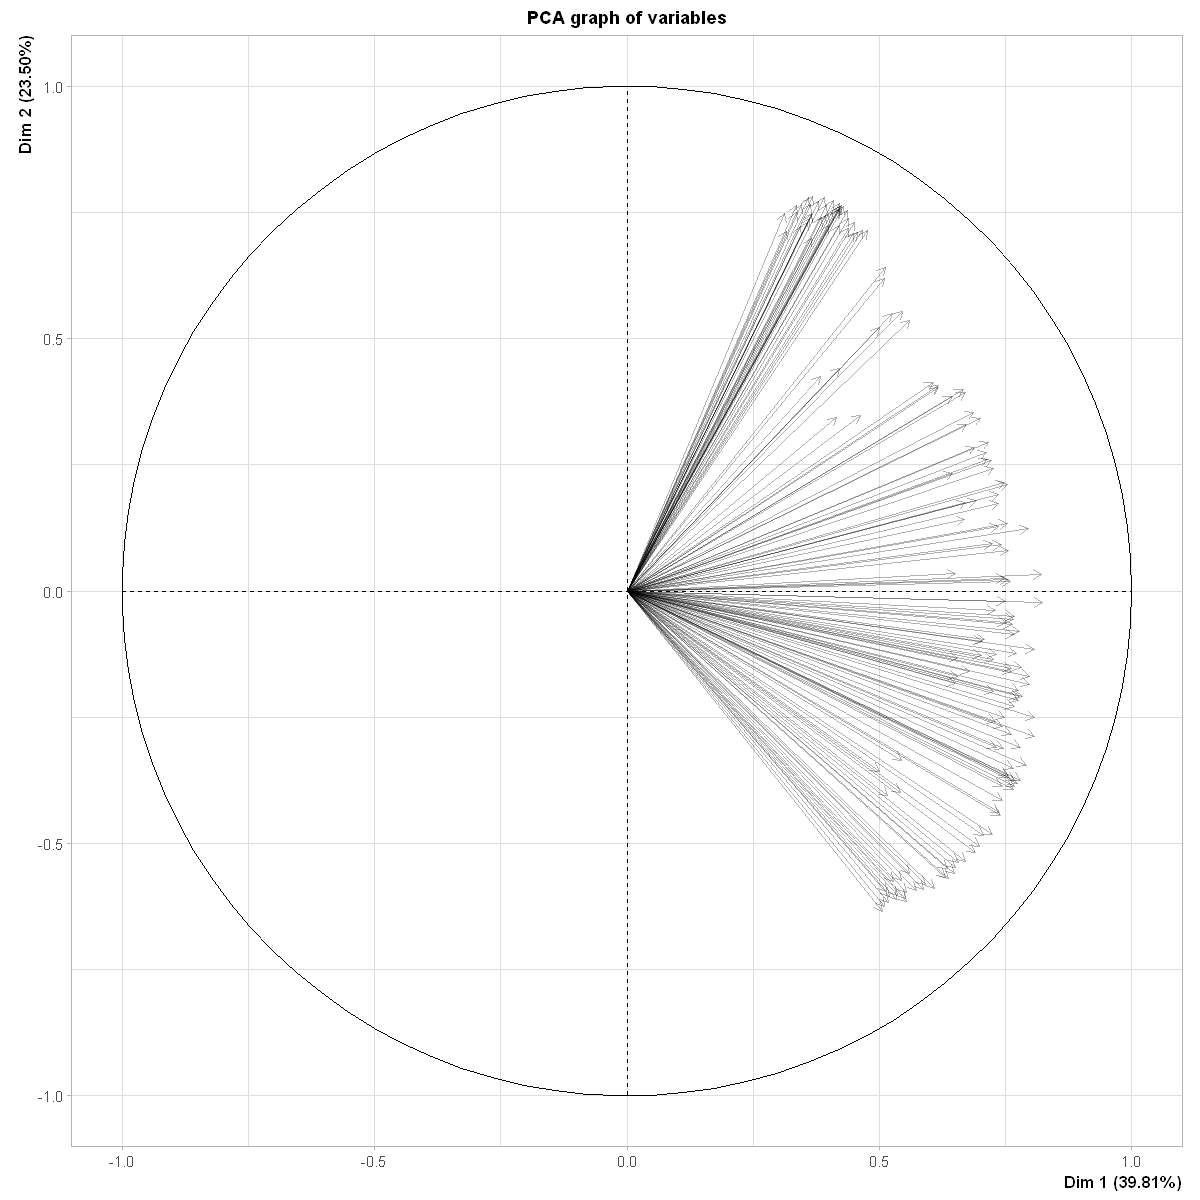

In [92]:
plot(acp, choix = "var", label = "none")

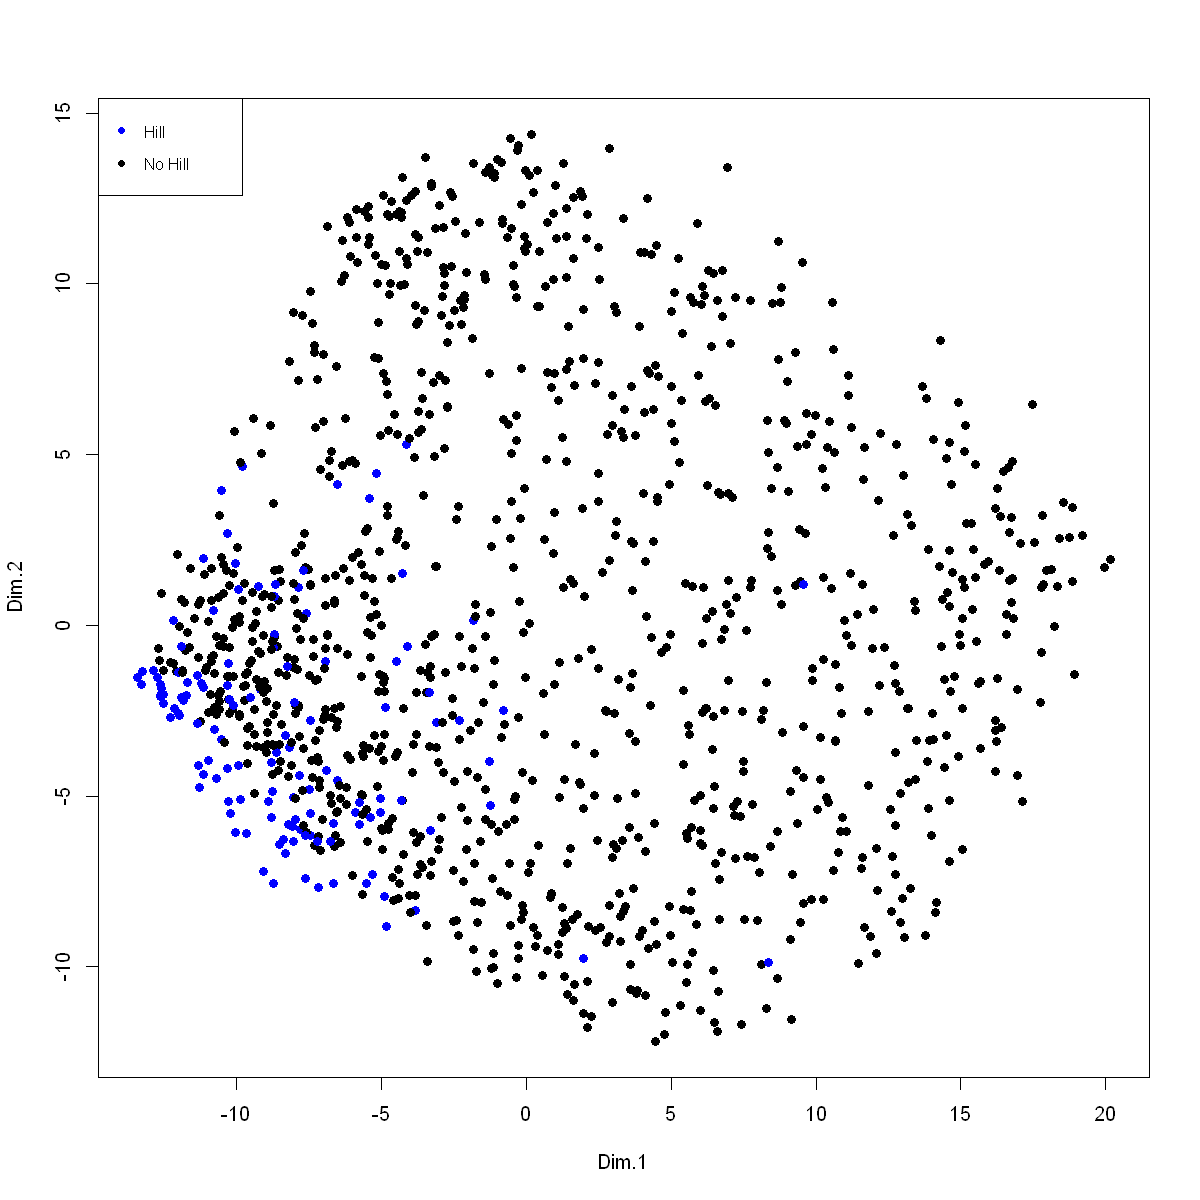

In [42]:
plot(acp$ind$coord, col = ifelse(velib$bonus,"blue","black"),
     pch = ifelse(velib$bonus,19,19))
legend("topleft", legend=c("Hill", "No Hill"), pch = c(19,19),
      col = c("blue","black"),cex = 0.8)